In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


got 1.10718

In [26]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [27]:
# Import Lab
import timeit
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize, stats                    
import pandas_profiling as autoprofiling
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

from keras.utils import np_utils
import tensorflow as tf


import gc
import pickle
import time
from itertools import product
import optuna
import lightgbm as lgb
from lightgbm import plot_importance

print('Done')

Done


data source :[ find it here ](#https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

shortcut: kaggle competitions download -c competitive-data-science-predict-future-sales

In [28]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [29]:
df_train.head()
df_test.head()
df_train.isnull().sum()
df_test.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [30]:
#autoprofiling.ProfileReport(df_train)

### Data Description
#### File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

####  Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


<AxesSubplot:>

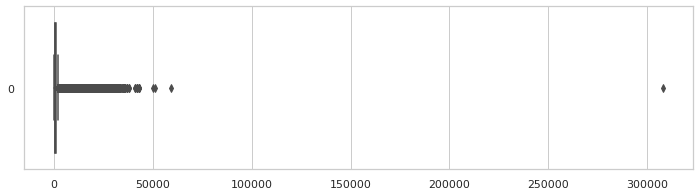

In [31]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 3))
sns.boxplot(data=df_train.item_price, orient='h')

In [32]:
# Remove large outliers
df_train = df_train[df_train.item_price < 100000]


<AxesSubplot:>

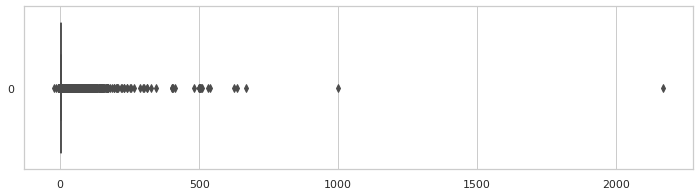

In [33]:
# let us zoom in
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_train.item_cnt_day, orient='h')


In [34]:
#once again Remove large outliers
df_train = df_train[df_train.item_cnt_day < 1000]

## Drop negative price 
df_train = df_train[df_train.item_price > 0].reset_index(drop=True) # drop 1

## The item has been returned 
df_train.loc[df_train.item_cnt_day < 0, 'item_cnt_day'] = 0

shops

In [35]:
df_shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Some shops have the same name (shops_id 0 - 57, 1 - 58, and 11 - 10), let's check again based on the opening and closing dates of the store, and check on the test data.

In [36]:
print('shops_id 0 and 57\n')
print(f'Shop_id 0  : Date = {df_train[df_train.shop_id == 0].date.min()} - {df_train[df_train.shop_id == 0].date.max()}')
print(f'Shop_id 57 : Date = {df_train[df_train.shop_id == 57].date.min()} - {df_train[df_train.shop_id == 57].date.max()}')

print('----'*10)

print('shops_id 1 and 58\n')
print(f'Shop_id 1  : Date = {df_train[df_train.shop_id == 1].date.min()} - {df_train[df_train.shop_id == 1].date.max()}')
print(f'Shop_id 58 : Date = {df_train[df_train.shop_id == 58].date.min()} - {df_train[df_train.shop_id == 58].date.max()}')

print('----'*10)

print('shops_id 10 and 11\n')
print(f'Shop_id 10  : Date = {df_train[df_train.shop_id == 10].date.min()} - {df_train[df_train.shop_id == 10].date.max()}')
print(f'Shop_id 11  : Date = {df_train[df_train.shop_id == 11].date.min()} - {df_train[df_train.shop_id == 11].date.max()}')

shops_id 0 and 57

Shop_id 0  : Date = 01.02.2013 - 31.01.2013
Shop_id 57 : Date = 01.02.2014 - 31.12.2014
----------------------------------------
shops_id 1 and 58

Shop_id 1  : Date = 01.02.2013 - 31.01.2013
Shop_id 58 : Date = 01.02.2014 - 31.12.2014
----------------------------------------
shops_id 10 and 11

Shop_id 10  : Date = 01.02.2013 - 31.12.2014
Shop_id 11  : Date = 01.02.2015 - 28.02.2015


#### symmetric_difference
shop_id which only exists in one of the data

In [37]:
a = df_train.shop_id.unique()
b = df_test.shop_id.unique()
print(f'shop_id which only exists in either one of the data ( train or test )\n{set(a) - set(b)}')

shop_id which only exists in either one of the data ( train or test )
{0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}


In [38]:
# shops_id 0, 1, and 11 are not in the test data
# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 11, 'shop_id'] = 10

In [39]:
# extracting city and category location from shop name

df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'  # fix name
df_shops['shop_city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops['shop_cat'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[1])
df_shops.head(5)

,shop_name,shop_id,shop_city,shop_cat
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [40]:
# labeling with label encoder for shops

df_shops['shop_city']  = LabelEncoder().fit_transform(df_shops['shop_city'] )
df_shops['shop_cat'] = LabelEncoder().fit_transform(df_shops['shop_cat'])
df_shops.drop(['shop_name'], axis=1, inplace= True)
df_shops.head(5)

,shop_id,shop_city,shop_cat
0,0,0,4
1,1,0,8
2,2,1,8
3,3,2,6
4,4,3,8


Items

In [41]:
# merge item data and item category data

df_items = pd.merge(df_items, df_item_categories, on = 'item_category_id')
df_items

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


In [42]:
# split item categories into several parts

df_items['item_sub_cat_1'] = np.select(
    [df_items.item_category_id.isin(range(0,8)),
    df_items.item_category_id.isin(range(10,18)),
    df_items.item_category_id.isin(range(18,32)),
    df_items.item_category_id.isin(range(32,37)),
    df_items.item_category_id.isin(range(37,42)),
    df_items.item_category_id.isin(range(42,55)),
    df_items.item_category_id.isin(range(55,61)),
    df_items.item_category_id.isin(range(61,73)),
    df_items.item_category_id.isin(range(73,79)),
    df_items.item_category_id.isin([8,80]),
    df_items.item_category_id==83, 
    df_items.item_category_id==9,
    df_items.item_category_id==79,  
    df_items.item_category_id.isin([81,82])],

    ['accessories','consoles','games','payment_cards','Cinema','books','music',
     'gifts','programs','tickets','batteries','delivery','office','discs'])

df_items

,item_name,item_id,item_category_id,item_category_name,item_sub_cat_1
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Cinema
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Cinema
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Cinema
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Cinema
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Cinema
...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,batteries
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,batteries
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,batteries
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,batteries


In [43]:
# label encoder for item_category and drop some colomns

df_items['item_sub_cat_1'] = LabelEncoder().fit_transform(df_items['item_sub_cat_1'])
df_items.drop(['item_name','item_category_name'], axis=1, inplace= True)
df_items

,item_id,item_category_id,item_sub_cat_1
0,0,40,0
1,2,40,0
2,3,40,0
3,4,40,0
4,5,40,0
...,...,...,...
22165,22095,83,2
22166,22096,83,2
22167,22097,83,2
22168,22098,83,2


### timing

In [60]:
# prepare train data

df_all = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num==i]
    df_all.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
df_all = pd.DataFrame(np.vstack(df_all), columns=cols)
df_all['date_block_num'] = df_all['date_block_num'].astype(np.int8)
df_all['shop_id'] = df_all['shop_id'].astype(np.int8)
df_all['item_id'] = df_all['item_id'].astype(np.int16)
df_all.sort_values(cols,inplace=True)
df_all

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
...,...,...,...
10768788,33,59,22162
10768978,33,59,22163
10769644,33,59,22164
10771170,33,59,22166


In [62]:
# prepare test data

#df_test.drop(['ID'], axis=1, inplace = True)
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num']
df_test['shop_id'] = df_test['shop_id']
df_test['item_id'] = df_test['item_id']
df_test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [63]:
# merger into data into one dataframe

df_all = pd.concat([df_all, df_test], ignore_index=True, sort=False, keys=cols)
df_all = pd.merge(df_all, df_shops, on=['shop_id'], how='left')
df_all = pd.merge(df_all, df_items, on=['item_id'], how='left')
df_all.fillna(0, inplace=True)
df_all

,date_block_num,shop_id,item_id,shop_city,shop_cat,item_category_id,item_sub_cat_1
0,0,2,19,1,8,40,0
1,0,2,27,1,8,19,7
2,0,2,28,1,8,30,7
3,0,2,29,1,8,23,7
4,0,2,32,1,8,40,0
...,...,...,...,...,...,...,...
11127999,34,45,18454,21,8,55,9
11128000,34,45,16188,21,8,64,8
11128001,34,45,15757,21,8,55,9
11128002,34,45,19648,21,8,40,0


In [64]:
# change type column to reduce memory use 

df_all.date_block_num    = df_all.date_block_num.astype(np.int8)
df_all.shop_id           = df_all.shop_id.astype(np.int8)
df_all.item_id           = df_all.item_id.astype(np.int16)
df_all.shop_city         = df_all.shop_city.astype(np.int8)
df_all.shop_cat          = df_all.shop_cat.astype(np.int8)
df_all.item_category_id  = df_all.item_category_id.astype(np.int8)
df_all.item_sub_cat_1    = df_all.item_sub_cat_1.astype(np.int8)

In [65]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def fill_na_test(df):
    for col in df.columns:
        if ('_lag' in col) & (df[col].isnull().any()):
            print(col)
            if ('month' in col):
                df[col].fillna(0, inplace=True)         
    return df

In [66]:
temp = df_train.groupby(['shop_id','item_id','date_block_num']).agg(item_cnt_month=('item_cnt_day',sum))
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=cols, how='left')
df_all['item_cnt_month'] = (df_all['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [67]:
ts = time.time()

# item_cnt_month

df_all = lag_feature(df_all, [1, 2, 3], 'item_cnt_month')


# Monthly - item_cnt_month

temp = df_all.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num'], how='left')
df_all = lag_feature(df_all, [1, 2, 3], 'avg_month')
df_all.drop(['avg_month'], axis=1, inplace= True)

# Monthly item - item_cnt_month

temp = df_all.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'item_id'], how='left')
df_all = lag_feature(df_all, [1, 2, 3], 'avg_item_month')
df_all.drop(['avg_item_month'], axis=1, inplace= True)

# Monthly shops - item_cnt_month

temp = df_all.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shop_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id'], how='left')
df_all = lag_feature(df_all, [1, 2, 3], 'avg_shop_month')
df_all.drop(['avg_shop_month'], axis=1, inplace= True)

# Monthly item_category - item_cnt_month

temp = df_all.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_cat_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'item_category_id'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_item_cat_month')
df_all.drop(['avg_item_cat_month'], axis=1, inplace= True)

# Monthly shops item_category - item_cnt_month

temp = df_all.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_itemcat_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_itemcat_month')
df_all.drop(['avg_shops_itemcat_month'], axis=1, inplace= True)

# Monthly shops item - item_cnt_month

temp = df_all.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_item_month')
df_all.drop(['avg_shops_item_month'], axis=1, inplace= True)

# Monthly shops subs_item category - item_cnt_month

temp = df_all.groupby(['date_block_num', 'shop_id', 'item_sub_cat_1']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_sub_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_sub_cat_1'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_item_sub_month')
df_all.drop(['avg_shops_item_sub_month'], axis=1, inplace= True)

# Monthly shops_city - item_cnt_month

temp = df_all.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shopscity_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_city'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shopscity_month')
df_all.drop(['avg_shopscity_month'], axis=1, inplace= True)

df_all

print('Use time:', time.time() - ts)


Use time: 246.4608006477356


In [68]:
# days, month, and year features

df_all['month'] = df_all['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df_all['days'] = df_all['month'].map(days)
df_all['years'] = np.select(
    [df_all.date_block_num.isin(range(0,12)),
     df_all.date_block_num.isin(range(12,25)),
     df_all.date_block_num.isin(range(25,35))],
    ['13','14','15'])

df_all['month'] = df_all['month'] + 1  # fix month

# change type column to reduce memory use

df_all['days'] = df_all['days'].astype(np.int8)
df_all['month'] = df_all['month'].astype(np.int8)
df_all['years'] = df_all['years'].astype(np.int8)
df_all

,date_block_num,shop_id,item_id,shop_city,shop_cat,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_month_lag_1,avg_month_lag_2,avg_month_lag_3,avg_item_month_lag_1,avg_item_month_lag_2,avg_item_month_lag_3,avg_shop_month_lag_1,avg_shop_month_lag_2,avg_shop_month_lag_3,avg_item_cat_month_lag_1,avg_item_cat_month_lag_2,avg_shops_itemcat_month_lag_1,avg_shops_itemcat_month_lag_2,avg_shops_item_month_lag_1,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days,years
0,0,2,19,1,8,40,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
1,0,2,27,1,8,19,7,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
2,0,2,28,1,8,30,7,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
3,0,2,29,1,8,23,7,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
4,0,2,32,1,8,40,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,21,8,55,9,0.000,1.000,0.000,0.000,0.259,0.264,0.289,0.045,0.023,0.071,0.127,0.129,0.139,0.197,0.178,0.127,0.075,1.000,0.000,0.089,0.054,0.135,0.139,11,30,15
11128000,34,45,16188,21,8,64,8,0.000,0.000,0.000,NaN,0.259,0.264,NaN,0.023,0.070,NaN,0.127,0.129,NaN,0.157,0.168,0.094,0.117,0.000,0.000,0.106,0.113,0.135,0.139,11,30,15
11128001,34,45,15757,21,8,55,9,0.000,0.000,0.000,0.000,0.259,0.264,0.289,0.114,0.070,0.095,0.127,0.129,0.139,0.197,0.178,0.127,0.075,0.000,0.000,0.089,0.054,0.135,0.139,11,30,15
11128002,34,45,19648,21,8,40,0,0.000,0.000,0.000,0.000,0.259,0.264,0.289,0.045,0.070,0.167,0.127,0.129,0.139,0.221,0.201,0.084,0.074,0.000,0.000,0.097,0.073,0.135,0.139,11,30,15


In [69]:
# The first month when one item is on sale

df_all['item_shop_first_sale'] = \
df_all['date_block_num'] - df_all.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

df_all['item_first_sale'] = \
df_all['date_block_num'] - df_all.groupby('item_id')['date_block_num'].transform('min')
df_all

,date_block_num,shop_id,item_id,shop_city,shop_cat,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_month_lag_1,avg_month_lag_2,avg_month_lag_3,avg_item_month_lag_1,avg_item_month_lag_2,avg_item_month_lag_3,avg_shop_month_lag_1,avg_shop_month_lag_2,avg_shop_month_lag_3,avg_item_cat_month_lag_1,avg_item_cat_month_lag_2,avg_shops_itemcat_month_lag_1,avg_shops_itemcat_month_lag_2,avg_shops_item_month_lag_1,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days,years,item_shop_first_sale,item_first_sale
0,0,2,19,1,8,40,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
1,0,2,27,1,8,19,7,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
2,0,2,28,1,8,30,7,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
3,0,2,29,1,8,23,7,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
4,0,2,32,1,8,40,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,21,8,55,9,0.000,1.000,0.000,0.000,0.259,0.264,0.289,0.045,0.023,0.071,0.127,0.129,0.139,0.197,0.178,0.127,0.075,1.000,0.000,0.089,0.054,0.135,0.139,11,30,15,11,11
11128000,34,45,16188,21,8,64,8,0.000,0.000,0.000,NaN,0.259,0.264,NaN,0.023,0.070,NaN,0.127,0.129,NaN,0.157,0.168,0.094,0.117,0.000,0.000,0.106,0.113,0.135,0.139,11,30,15,2,2
11128001,34,45,15757,21,8,55,9,0.000,0.000,0.000,0.000,0.259,0.264,0.289,0.114,0.070,0.095,0.127,0.129,0.139,0.197,0.178,0.127,0.075,0.000,0.000,0.089,0.054,0.135,0.139,11,30,15,34,34
11128002,34,45,19648,21,8,40,0,0.000,0.000,0.000,0.000,0.259,0.264,0.289,0.045,0.070,0.167,0.127,0.129,0.139,0.221,0.201,0.084,0.074,0.000,0.000,0.097,0.073,0.135,0.139,11,30,15,11,11


In [56]:
# check null data 
df_all.isnull().any()

date_block_num                    False
shop_id                           False
item_id                           False
shop_city                         False
shop_cat                          False
item_category_id                  False
item_sub_cat_1                    False
item_cnt_month                    False
item_cnt_month_lag_1               True
item_cnt_month_lag_2               True
item_cnt_month_lag_3               True
avg_month_lag_1                    True
avg_month_lag_2                    True
avg_month_lag_3                    True
avg_item_month_lag_1               True
avg_item_month_lag_2               True
avg_item_month_lag_3               True
avg_shop_month_lag_1               True
avg_shop_month_lag_2               True
avg_shop_month_lag_3               True
avg_item_cat_month_lag_1           True
avg_item_cat_month_lag_2           True
avg_shops_itemcat_month_lag_1      True
avg_shops_itemcat_month_lag_2      True
avg_shops_item_month_lag_1         True


In [70]:
# fill null data with zero (0)
df_all = fill_na_test(df_all)
df_all.isnull().any()

item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3
avg_month_lag_1
avg_month_lag_2
avg_month_lag_3
avg_item_month_lag_1
avg_item_month_lag_2
avg_item_month_lag_3
avg_shop_month_lag_1
avg_shop_month_lag_2
avg_shop_month_lag_3
avg_item_cat_month_lag_1
avg_item_cat_month_lag_2
avg_shops_itemcat_month_lag_1
avg_shops_itemcat_month_lag_2
avg_shops_item_month_lag_1
avg_shops_item_month_lag_2
avg_shops_item_sub_month_lag_1
avg_shops_item_sub_month_lag_2
avg_shopscity_month_lag_1
avg_shopscity_month_lag_2


date_block_num                    False
shop_id                           False
item_id                           False
shop_city                         False
shop_cat                          False
item_category_id                  False
item_sub_cat_1                    False
item_cnt_month                    False
item_cnt_month_lag_1              False
item_cnt_month_lag_2              False
item_cnt_month_lag_3              False
avg_month_lag_1                   False
avg_month_lag_2                   False
avg_month_lag_3                   False
avg_item_month_lag_1              False
avg_item_month_lag_2              False
avg_item_month_lag_3              False
avg_shop_month_lag_1              False
avg_shop_month_lag_2              False
avg_shop_month_lag_3              False
avg_item_cat_month_lag_1          False
avg_item_cat_month_lag_2          False
avg_shops_itemcat_month_lag_1     False
avg_shops_itemcat_month_lag_2     False
avg_shops_item_month_lag_1        False


In [71]:
df_all.to_pickle('dataset.pkl')

In [72]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 35 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int8   
 1   shop_id                         int8   
 2   item_id                         int16  
 3   shop_city                       int8   
 4   shop_cat                        int8   
 5   item_category_id                int8   
 6   item_sub_cat_1                  int8   
 7   item_cnt_month                  float16
 8   item_cnt_month_lag_1            float16
 9   item_cnt_month_lag_2            float16
 10  item_cnt_month_lag_3            float16
 11  avg_month_lag_1                 float16
 12  avg_month_lag_2                 float16
 13  avg_month_lag_3                 float16
 14  avg_item_month_lag_1            float16
 15  avg_item_month_lag_2            float16
 16  avg_item_month_lag_3            float16
 17  avg_shop_month_lag_1     

In [76]:
df_train.head

<bound method NDFrame.head of                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154     999.000   
1        03.01.2013               0       25     2552     899.000   
2        05.01.2013               0       25     2552     899.000   
3        06.01.2013               0       25     2554    1709.050   
4        15.01.2013               0       25     2555    1099.000   
...             ...             ...      ...      ...         ...   
2935840  10.10.2015              33       25     7409     299.000   
2935841  09.10.2015              33       25     7460     299.000   
2935842  14.10.2015              33       25     7459     349.000   
2935843  22.10.2015              33       25     7440     299.000   
2935844  03.10.2015              33       25     7460     299.000   

         item_cnt_day  
0               1.000  
1               1.000  
2               0.000  
3               1.000  
4               1.000

In [74]:
## monthly sales
df = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', fill_value=0, aggfunc='sum')
df = df.reset_index()
df.columns.name = None
df



TypeError: No matching signature found

#### Merge past data to test one

In [ ]:
df_test_src = pd.merge(df_test, df, how='left', on=['shop_id', 'item_id'])
df_test_src = df_test_src.drop(['ID'], axis=1).fillna(0)
df_test_src

In [ ]:
stop checkpoint 1

### feeding only explanatory and objective variables

In [ ]:
X_train = df.iloc[:, 2:-1]
X_train

In [ ]:
y_train = df.iloc[:, -1]
y_train

In [ ]:
X_test = df_test_src.iloc[:, 3:]
X_test

In [ ]:
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test  = X_scaler.transform(X_test)


Model

In [ ]:
input = tf.keras.layers.Input(shape=(33, 1))

x = input
x = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(32)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(input, output)
model.summary()


In [ ]:
model.compile(optimizer='adam', loss='mse')


### Training 

In [ ]:
epochs = 100
batch_size = 64

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(np.expand_dims(X_train, axis=-1),
                    y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)


### Prediction

In [ ]:
y_pred = model.predict(np.expand_dims(X_test, -1))
y_pred

In [ ]:
y_pred = y_pred.squeeze().clip(0, 20)
y_pred

In [ ]:
submission = pd.concat([df_test['ID'], pd.Series(y_pred.squeeze(), name='item_cnt_month')], axis=1)
submission

In [ ]:
submission.to_csv("submission_2.csv", index=False)